# Running GPT-2 Locally

https://huggingface.co/openai-community/gpt2?library=transformers

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

In [2]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

## Tokenize Text

We have some text and we would like to predict the next few characters of text. We cannot simply input our text into the model because our model doesn't speak in language; it speaks in numbers!

The first step to almost any NLP task is to turn our language into some sort of series vectors or number. In our setting, we apply a "tokenizer" to split up the text into chunks, where each chunch is assigned a number. From here we can print the numbers out to inspect them. These will be fed to the model, which will turn each of these numbers into a high-dimensional vector, for our tranformer to perform computations on and learn relationship in the text useful for predicting the next token.

Take a look at the example below for how to tokenize the string: "The great scientist Albert"

In [3]:
prefix = "The great scientist Albert"
encoded_input = tokenizer(prefix, return_tensors='pt')
print(encoded_input['input_ids'])

tensor([[  464,  1049, 11444,  9966]])


Our tokenizer can also decode these ids back into the original text. For example:

In [4]:
tokenizer.decode(encoded_input['input_ids'][0])

'The great scientist Albert'

### Task #1

For a given input of text, return a list of tokens in plain text. For example for the input "Hello there", the function should return ['Hello', ' there', ' g', 'pt', '-', '2']. Note that this is very different than just splitting up the text into random chunks or where there are spaces! Tokenizers are designed to create groupings of characters that are often found together or that are significant in the structure of language. Tokenizers make it easier to for the model to learn by providing an algorithm to group language together in a way that helpf the model learn. 

Hint: You only need to call tokenizer and tokenizer.decode to complete this task!

In [5]:
def plain_text_tokens(prefix):
    '''
    Tokenizes prefix and list of it's tokens in plain text
    '''
    rv = []
    encoded_input = tokenizer(prefix, return_tensors='pt')
    for i in encoded_input['input_ids'][0]:
        rv.append(tokenizer.decode([i]))
    return rv
 
plain_text_tokens("Hello there gpt-2")

['Hello', ' there', ' g', 'pt', '-', '2']

Back to our model. We will tokenize our text into numbers to feed into the model. When the model is done predicting text, we can untokenize the results to see if what the model is saying makes sense.

Below is some code for the one full pass through the model with the prefix "The great scientist Albert Einstein"

Take a look at the shape of the output.

In [6]:
prefix = "The great scientist Albert"
encoded_input = tokenizer(prefix, return_tensors='pt')
output = model(**encoded_input)
logits = output.logits
logits.shape

torch.Size([1, 4, 50257])

Let's take another look at the logit values. Note that the values span a huge positive and negative range. Normally, both in training and in inference, we apply a "softmax" function to the data to bring all values between 0 and 1. We interpret these values as the probability that the model assigns each token to be next in a sequence of text. For now however, we ignore this detail.

In [19]:
max(logits.view(-1)), min(logits.view(-1))

(tensor(69.1329, grad_fn=<UnbindBackward0>),
 tensor(-313.3790, grad_fn=<UnbindBackward0>))

In [7]:
encoded_input['input_ids']

tensor([[  464,  1049, 11444,  9966]])

What is going on here?

`torch.Size([1, 4, 50257])` tells us that logits is a 3 dimensional array (i.e., it is 1*4*50257). The first dimension represents the batch size and because there is only one batch, we can ignore it for now. The next dimension is the sequence length. Note that:

```python
>>> encoded_input['input_ids']
tensor([[  464,  1049, 11444,  9966]])
```

There are four tokens when we tokenize "The great scientist Albert" so there will therefore be a sequence length of 4. For the final dimension, we have 50257 which represents the model's vocab size. Why do we have so much data? Don't we only want the next predicted piece of text? 

This is actually very necessary and it gives us a lot of control in analysis of the model. In total, we have 4 vectors of length 50257. Each vector represents a probability distribution for each token in the vocabulary. For example, if the value at 2048 is higher, that means that the model is assigning a higher probability to the token at position 2048 to be the next in the sequence of text.

This makes sense for our purposes: if we have a probability distribution for the next token in the text, we can sample from it to predict the next token! But why do we have four probability distributions in the output. In other words why do we need a probability distribution for each token in the input?

The answer to this question is oddly, that this make it easier to train our model! If we have a piece of text that we are training on from the internet, we can train multiple examples in paralell. For example, if we have the text "The great scientist Albert" here are a few different examples we could choose to train on. 


1. Prefix="The" and label=" great"
2. Prefix="The great" and label=" scientist"
3. Prefix="he great scientist" and label=" Albert"


The first three vectors in the logits in the code above correspond to the model's predictions for the first three prefixes above. We only care about the model's label for the input "The great scientist Albert" so therefore, we only need to extract the final vector from the probability distribution. This makes sense because for our purposes, we aren't training the model. We are only interested in seeing what the model predicts for the next token.

We can extract this last vector by taking `logits[0][-1]`. Lets see what the model predicts!

In [9]:
text = "The great scientist Albert Einstein"

encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
logits = output.logits  # Shape: (batch_size, sequence_length, vocab_size)
token_id = torch.argmax(logits[0][-1])

generated_text = tokenizer.decode([token_id.item()]) 
print(generated_text)

,


In [10]:
for i in range(100):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    logits = output.logits  # Shape: (batch_size, sequence_length, vocab_size)
    token_id = torch.argmax(logits[0][-1])

    generated_text = tokenizer.decode([token_id.item()])  
    text+=generated_text

In [11]:
text

'The great scientist Albert Einstein, who was a great scientist, was a great scientist. He was a great scientist. He was a great scientist. He was a great scientist. He was a great scientist. He was a great scientist. He was a great scientist. He was a great scientist. He was a great scientist. He was a great scientist. He was a great scientist. He was a great scientist. He was a great scientist. He was a great scientist. He was a great scientist. He was a great'

### Why is the model repeating itself?

In the previous cell, we generated text by always choosing the **most likely next token** (using `torch.argmax`). This deterministic approach has a major drawback: once the model enters a pattern that has high probability, it can get stuck in a loop.

Think of it like this: if the model strongly believes that "Einstein was" should be followed by "a physicist", and then strongly believes "a physicist" should be followed by "who", and then that sequence loops back to another high-probability path, the model will repeat this pattern indefinitely.

### Introducing Temperature

**Temperature** is a hyperparameter that controls the randomness of predictions by scaling the logits before applying softmax. Mathematically:

$$p_i = \frac{\exp(z_i/T)}{\sum_j \exp(z_j/T)}$$

Where:
- $z_i$ are the logits (raw model outputs)
- $T$ is the temperature parameter
- $p_i$ is the resulting probability for token $i$

### Effects of different temperature values:

- **T = 0** (or very close to 0): Completely deterministic, always pick highest probability token (like we did before)
- **T = 1.0**: Standard softmax, use the exact probabilities from the model
- **T > 1.0**: More uniform distribution, increasing randomness and diversity
- **T < 1.0**: More peaked distribution, reducing randomness but still allowing some

Lower temperatures produce more focused, coherent text but risk repetition. Higher temperatures produce more diverse, creative text but risk incoherence.

In the next cell, we'll implement temperature sampling to fix our repetition problem!

In [13]:
def generate_with_temperature(model, tokenizer, prompt, max_length=100, temperature=0.7):
    # Start with the provided prompt
    generated_text = prompt
    
    for _ in range(max_length):
        # Tokenize the current text
        inputs = tokenizer(generated_text, return_tensors='pt')
        
        # Get model output
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
        
        # Get the next token logits (last position in sequence)
        next_token_logits = logits[0, -1, :]
        
        # Apply temperature
        scaled_logits = next_token_logits / temperature
        
        # Convert to probabilities with softmax
        probs = F.softmax(scaled_logits, dim=0)
        
        # Sample from the distribution
        next_token_id = torch.multinomial(probs, num_samples=1).item()
        
        # Decode the token and add to generated text
        next_token_text = tokenizer.decode([next_token_id])
        generated_text += next_token_text
        
    return generated_text

In [14]:
# Low temperature (more deterministic but not completely)
prompt = "The great scientist Albert Einstein"
low_temp_text = generate_with_temperature(
    model, tokenizer, prompt, max_length=50, temperature=0.3
)
print("Temperature = 0.3:")
print(low_temp_text)
print("\n" + "-"*50 + "\n")

# Medium temperature (balanced)
medium_temp_text = generate_with_temperature(
    model, tokenizer, prompt, max_length=50, temperature=0.7
)
print("Temperature = 0.7:")
print(medium_temp_text)
print("\n" + "-"*50 + "\n")

# High temperature (more random)
high_temp_text = generate_with_temperature(
    model, tokenizer, prompt, max_length=50, temperature=1.2
)
print("Temperature = 1.2:")
print(high_temp_text)

Temperature = 0.3:
The great scientist Albert Einstein, who was the first to see the potential of quantum mechanics, was the first to see the potential of quantum mechanics, and he was the first to see the potential of quantum mechanics. He was the first to see the potential of quantum mechanics. He

--------------------------------------------------

Temperature = 0.7:
The great scientist Albert Einstein (1850-1917) has been considered one of the greatest minds in the history of science. Einstein was known as one of the most important minds of the twentieth century. His work was "the scribe of history" and to use his

--------------------------------------------------

Temperature = 1.2:
The great scientist Albert Einstein stated that we must underrealize our geospaces at the frequency of weaponization. His judgement was especially important specifically in the most distant era Jean Valjean, a Parisian celebrated mathematician and any competent observer of solar systems, said now abou

# Stealing Model Dims

## Credit:

This section is based entirely on ideas from the paper "Stealing Part of a Production Language Model" by Nicholas Carlini, Daniel Paleka, Krishnamurthy Dj Dvijotham, Thomas Steinke, Jonathan Hayase, A. Feder Cooper, Katherine Lee, Matthew Jagielski, Milad Nasr, Arthur Conmy, Itay Yona, Eric Wallace, David Rolnick, Florian Tramèr

You can find the full paper here:
https://arxiv.org/pdf/2403.06634

When a language model processes text, the final layer projects from a hidden dimension $h$ to vocabulary size $l$. This creates a bottleneck - no matter how many different inputs we try, the output logits can only span a subspace of dimension h. If you haven't taken a linear algebra class you can think about this more simply: we are expanding out a vector that is smaller into a vector that this larger using a constant transformation. The complexity of the output is determined by the complexity of the input. If you try to blow up a 2D vector into 3D space with a constant transformation, the possible outputs can be defined as a plane (a 2D shape in 3D space).

By collecting many logit vectors and analyzing their singular values, we can determine this hidden dimension. If you haven't taken linear algebra before, you can think of the number of non-zero singular values to determine how big a space a matrix spans. So maybe a matrix is really large, but all of it's columns are multiples of eachother. Then we would say that that matrix spans a smaller subspace. 

--> add examples here zephy!

In theory, there should be exactly h non-zero singular values. In practice, due to numerical precision, we look for a sharp drop in the magnitude of singular values, which appears as a large gap in the log-differences.

## RandPrefix()

In algorithm \#1 of the paper, we generate RandPrefix() n times. The code for RandPrefix is below. We need to query the model with different inputs to collect logit vectors. This function creates random text prompts.

In [27]:
def generate_random_prefix(tokenizer):
    """
    Generates a random text prefix to query the model
    """
    # Create a random prompt of 5-10 tokens
    length = np.random.randint(5, 10)
    # Sample random token IDs (avoiding special tokens)
    token_ids = np.random.randint(100, min(30000, len(tokenizer)), size=length)
    # Convert to a prompt
    text = tokenizer.decode(token_ids)
    return text

### Collecting Logit Vectors: The Mathematical Foundation

In transformer language models, logits are generated as:

$$f_\theta(p) = \text{softmax}(\mathbf{W} \cdot g_\theta(p))$$

Where:
- $\mathbf{W}$ is an $l \times h$ matrix (vocabulary size × hidden dimension). This is a matrix that expands out the size of model's output to the vocabulary size of the model, so we can extract a predicition on it.
- $g_\theta(p)$ outputs an $h$-dimensional hidden state vector. This $h$ dim vector represents the output of the model before we expand it out to extract predictions. The value of $h$ will be less than $l$ for efficiency reasons.

The crucial insight: **output logits can only span a subspace of dimension $h$**, regardless of how many different prompts we try.

For any set of prompts $p_1, p_2, ..., p_n$, the matrix $\mathbf{Q}$ with columns of logit vectors will have:

$$h \geq \text{rank}(\mathbf{Q})$$

And if we collect enough diverse prompts:

$$h = \text{rank}(\mathbf{Q})$$

This function:
1. Creates matrix $\mathbf{Q}$ of size `num_queries × l`
2. Generates random prompts to obtain diverse hidden states
3. Collects logit vectors as rows in $\mathbf{Q}$

When `num_queries > h`, the matrix $\mathbf{Q}$ will have rank exactly $h$, allowing us to determine the hidden dimension by analyzing its singular values.

The `vocab_subset_size` parameter is an optimization that reduces computation without affecting the mathematical validity, since we only need a subset of the vocabulary that's larger than $h$.

In [28]:
def collect_logit_vectors(model, tokenizer, num_queries, vocab_subset_size=None):
    """
    Queries the model with random prefixes and collects logit vectors
    """
    # Determine vocabulary size to use
    l = vocab_subset_size if vocab_subset_size else len(tokenizer)
    
    # Matrix Q will store logits from all queries
    Q = np.zeros((num_queries, l))
    
    # Run queries to collect logits
    for i in range(num_queries):
        # Generate a random prefix
        prefix = generate_random_prefix(tokenizer)
        
        # Tokenize the prefix
        inputs = tokenizer(prefix, return_tensors='pt')
        
        # Get model logits
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
        
        # Extract the logits for the last token
        last_token_logits = logits[0, -1, :]
        
        # Store in Q matrix (using a subset of vocabulary if specified)
        if vocab_subset_size:
            Q[i, :] = last_token_logits[:vocab_subset_size].numpy()
        else:
            Q[i, :] = last_token_logits.numpy()
        
        if (i+1) % 100 == 0:
            print(f"Processed {i+1}/{num_queries} queries")
    
    return Q

### Analyzing Singular Values to Determine Hidden Dimension

This function implements the core mathematical insight from Algorithm 1 in the paper: finding the hidden dimension using Singular Value Decomposition (SVD).

When we perform SVD on the matrix $\mathbf{Q}$, we get singular values $\lambda_1 \geq \lambda_2 \geq ... \geq \lambda_n$. In theory, if the matrix has rank exactly $h$, then:

$$\lambda_1, \lambda_2, ..., \lambda_h > 0 \quad \text{and} \quad \lambda_{h+1}, ..., \lambda_n = 0$$

However, in practice with floating-point computations, the "zero" singular values will be small but non-zero. The paper notes that we should see a significant drop in magnitude between $\lambda_h$ and $\lambda_{h+1}$.

To detect this "cliff edge" reliably, we:
1. Transform singular values to log-space
2. Calculate differences between consecutive log singular values: $\log(\lambda_i) - \log(\lambda_{i+1})$
3. Find the index with the largest gap: $\arg\max_i (\log(\lambda_i) - \log(\lambda_{i+1}))$

This approach is more robust to numerical precision issues than directly checking for near-zero values. The paper found it accurately identifies the hidden dimension across various models including GPT-2, Pythia, and LLaMA variants.

The function visualizes both:
- The singular values themselves (on a log scale)
- The differences between consecutive log singular values, clearly showing the "cliff edge" at position $h$

In [32]:
def analyze_hidden_dimension(Q):
    """
    Analyzes the singular values of the logit matrix to find the hidden dimension
    """
    # Compute singular values of Q
    singular_values = np.linalg.svd(Q, compute_uv=False)
    
    # Plot the singular values
    plt.figure(figsize=(10, 6))
    plt.semilogy(singular_values, label='Singular Values')
    plt.title('Singular Values of Logit Output Matrix')
    plt.xlabel('Index')
    plt.ylabel('Magnitude (log scale)')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Find the largest gap between consecutive log singular values
    log_s_values = np.log(singular_values)
    log_diffs = log_s_values[:-1] - log_s_values[1:]
    
    # The hidden dimension is the index of the largest gap + 1
    # We only count diffs after the first 5 because we know the model hidden dim will be more than 5
    hidden_dim = np.argmax(log_diffs[5:]) + 1
    
    # Also plot the differences to show the gap
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(log_diffs)+1), log_diffs)
    plt.axvline(x=hidden_dim, color='r', linestyle='--', 
                label=f'Hidden Dimension = {hidden_dim}')
    plt.title('Difference Between Consecutive Log Singular Values')
    plt.xlabel('Index')
    plt.ylabel('Log Difference')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return hidden_dim

In [33]:
def extract_hidden_dimension(model, tokenizer, num_queries=3000, vocab_subset_size=None):
    """
    Extracts the hidden dimension of a language model.
    
    Args:
        model: The language model to analyze
        tokenizer: The tokenizer for the model
        num_queries: Number of random prompts to generate (should be > hidden dimension)
        vocab_subset_size: Optional size to limit vocabulary (for efficiency)
        
    Returns:
        The estimated hidden dimension
    """
    # Step 1: Collect logit vectors
    print("Collecting logit vectors...")
    Q = collect_logit_vectors(model, tokenizer, num_queries, vocab_subset_size)
    
    # Step 2: Analyze singular values to find hidden dimension
    print("Analyzing singular values...")
    hidden_dim = analyze_hidden_dimension(Q)
    
    return hidden_dim

Extracting hidden dimension of the model...
Processed 100/1000 queries
Processed 200/1000 queries
Processed 300/1000 queries
Processed 400/1000 queries
Processed 500/1000 queries
Processed 600/1000 queries
Processed 700/1000 queries
Processed 800/1000 queries
Processed 900/1000 queries
Processed 1000/1000 queries
Analyzing singular values...


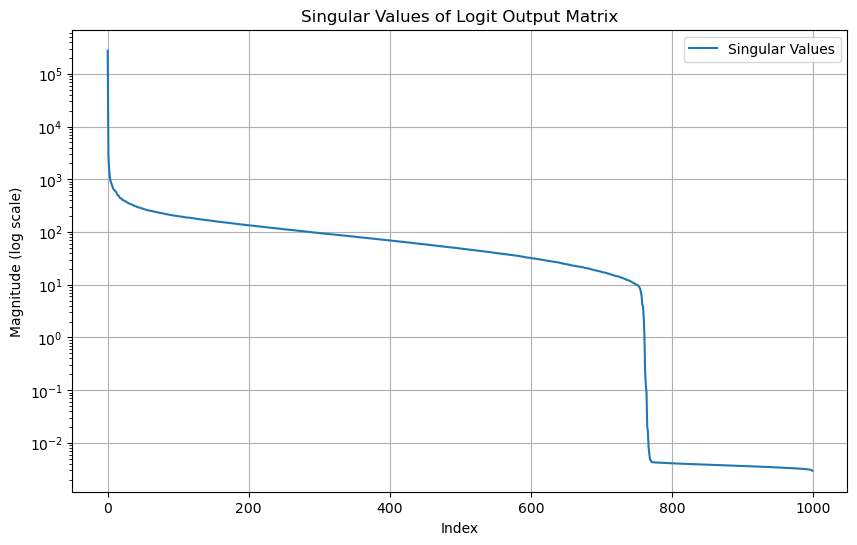

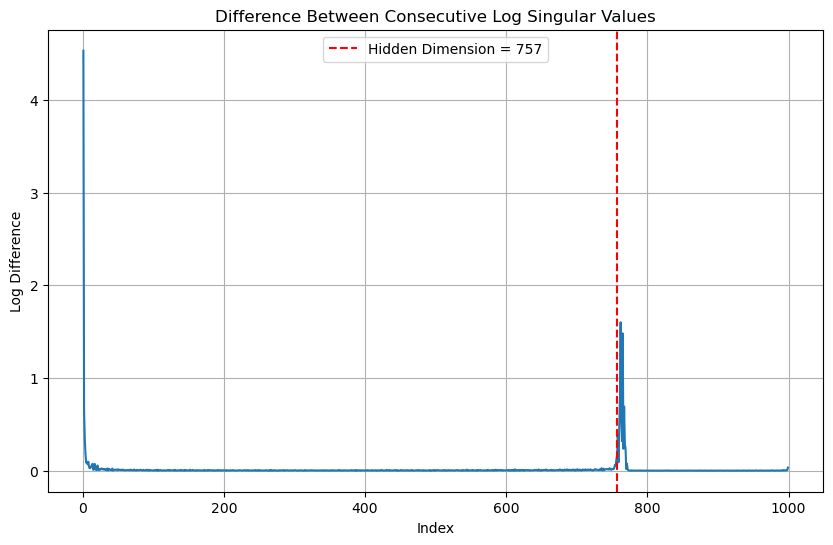

Estimated hidden dimension: 757
Actual hidden dimension of GPT-2: 768


In [34]:
# For efficiency in this demonstration, we'll use a subset of vocabulary
# and a smaller number of queries
num_queries = 1000  # In practice, this should be > h
vocab_subset_size = 10000  # Reduce computation for SVD

print("Extracting hidden dimension of the model...")
hidden_dim = extract_hidden_dimension(model, tokenizer, 
                                     num_queries=num_queries,
                                     vocab_subset_size=vocab_subset_size)

print(f"Estimated hidden dimension: {hidden_dim}")
print(f"Actual hidden dimension of GPT-2: 768")  # For GPT-2 small